#### Prepare Dataset
- Install Packages
- Import Packages
- Download Data

##### Install Packages

In [1]:
# pip install copernicus_marine_client

In [2]:
# pip install keras-tuner --upgrade

##### Import Packages

In [3]:
import os
import xarray as xr
import copernicus_marine_client as copernicusmarine

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from glob import glob

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import *
from tensorflow.keras import Sequential
from tensorflow.keras.regularizers import l1_l2
import keras_tuner

2023-12-18 17:26:35.057996: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-12-18 17:26:35.100992: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


##### Download Data  
- Download data from source website form two dataset_id
- Merge two dataset

In [4]:
# Download data from source website form two dataset_id
copernicusmarine.login("xfeng4","Sf1260358662@") #login, overwrite it ? [y/N]: y

#field name in dataset
data_variables = ["sithick","siconc","thetao","bottomT","so", "usi", "vsi","uo","vo"]

#create folder to store raw data
cwd = os.getcwd()
folder = "sea ice thickness dataset"
site = "greenland" #create dictionary: {site: lat and long range}
folder_path = os.path.join(cwd, folder, site) 
os.makedirs(folder_path, exist_ok=True) 

File /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials already exists, overwrite it ? [y/N]:

  y


INFO - 2023-12-18T17:26:48Z - Credentials file stored in /home/jovyan/.copernicus-marine-client/.copernicus-marine-credentials.


In [5]:
#first dataset
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id1.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_my_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=-58.133,
          maximum_longitude=-57.718,
          minimum_latitude=82.892,
          maximum_latitude=83.307,
          start_datetime="1993-01-01T00:00:00",
          end_datetime="2021-06-30T23:59:59",
          output_filename=output_file)

#second dataset ID
for var in data_variables:
    output_file = os.path.join(folder_path, f"{var}_id2.nc")
    if os.path.exists(output_file):
        pass
    else:
        copernicusmarine.subset(
          dataset_id="cmems_mod_glo_phy_myint_0.083deg_P1D-m",
          variables=[var],
          minimum_longitude=-58.133,
          maximum_longitude=-57.718,
          minimum_latitude=82.892,
          maximum_latitude=83.307,
          start_datetime="2021-07-01T00:00:00",
          end_datetime="2023-07-31T23:59:59",
          output_filename=os.path.join(folder_path, f"{var}_id2.nc"))
        
print("down")

down


In [6]:
#Merge two dataset
os.makedirs(os.path.join(folder_path, "Merged"), exist_ok=True) 

for var in data_variables:
    output_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    if os.path.exists(output_file):
        pass
    else:
        data_id1_file = os.path.join(folder_path, f"{var}_id1.nc")
        data_id2_file = os.path.join(folder_path, f"{var}_id2.nc")
        data_id1_xr = xr.open_dataset(data_id1_file)
        data_id2_xr = xr.open_dataset(data_id2_file)
        data_xr = xr.merge([data_id1_xr, data_id2_xr])
        data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
        data_xr.to_netcdf(data_file)
        
print("down")

down


#### Process Data
- read as xarray, drop "depth" dimension, and merge xrray
- normalization
- flat data for NN
- time slider for LSTM

##### Read as xarray, drop "depth" dimension, and merge xarray

In [7]:
#extract training_data
#create variable for time slice
training_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=slice('1993-01-01', '2018-12-31'))

    if 'depth' in selection_dataset_time[var].dims: #drop "depth" if it exists
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans: #complete data via linear interpolate
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    training_data[var] = selection_dataset_time

#check if dimensions same: only keep time, lat and lon
dimensions = None
for var, dataset in training_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

train = xr.merge([training_data[var] for var in data_variables])

#get input and output variables 
x_train_xr = train[["siconc", "thetao", "bottomT", "so", "usi", "vsi", "uo", "vo"]]
y_train_xr = train["sithick"]

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


In [8]:
#extract testing_data
#write a function for extract and merge
testing_data = {}
for var in data_variables:
    data_file = os.path.join(folder_path, "Merged", f"{var}_merged.nc")
    selection_dataset = xr.open_dataset(data_file)
    selection_dataset_time = selection_dataset.sel(time=slice('2019-01-01', '2023-07-31'))

    if 'depth' in selection_dataset_time[var].dims:
        selection_dataset_time[var] = selection_dataset_time[var].mean(dim='depth')
        selection_dataset_time = selection_dataset_time.drop_vars("depth")
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')
    else:
        check_nans = selection_dataset_time[var].isnull().any()
        if check_nans:
            selection_dataset_time[var] = selection_dataset_time[var].interpolate_na(dim='time')

    testing_data[var] = selection_dataset_time
    
dimensions = None
for var, dataset in testing_data.items():
    if dimensions is None:
        dimensions = dataset.dims
    elif dimensions != dataset.dims:
        raise ValueError(f"Dimension mismatch in variable {var}")

test = xr.merge([testing_data[var] for var in data_variables])

x_test_xr = test[["siconc", "thetao", "bottomT", "so", "usi", "vsi", "uo", "vo"]]
y_test_xr = test["sithick"]

/srv/conda/envs/notebook/lib/python3.10/site-packages/xarray/core/utils.py:494: FutureWarning: The return type of `Dataset.dims` will be changed to return a set of dimension names in future, in order to be more consistent with `DataArray.dims`. To access a mapping from dimension names to lengths, please use `Dataset.sizes`.
  warnings.warn(


##### Normalization

In [9]:
meanstd_inputs = {}
predictors = ["siconc", "thetao", "bottomT", "so", "usi", "vsi", "uo", "vo"]

def normalize(data, var, meanstd_dict):
    mean = meanstd_dict[var][0]
    std = meanstd_dict[var][1]
    return (data - mean)/std

for var in predictors:
    meanstd_inputs[var] = (x_train_xr[var].data.mean(), x_train_xr[var].data.std())
    
# normalize each variables
for var in predictors:
    # training set
    var_dims   = x_train_xr[var].dims
    x_train_xr = x_train_xr.assign({var: (var_dims, normalize(x_train_xr[var].data, var, meanstd_inputs))})
    
    # test set
    var_dims  = x_test_xr[var].dims
    x_test_xr = x_test_xr.assign({var: (var_dims, normalize(x_test_xr[var].data, var, meanstd_inputs))})

In [10]:
x_train_np  = x_train_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data
x_test_np  = x_test_xr.to_array().transpose('time', 'latitude', 'longitude', 'variable').data

y_train_np = y_train_xr.data
y_test_np = y_test_xr.data

print(x_train_np.shape, x_test_np.shape, y_train_np.shape, y_test_np.shape)

(9496, 5, 5, 8) (1673, 5, 5, 8) (9496, 5, 5) (1673, 5, 5)


##### Flat data for NN

In [15]:
#convert model to 1D for NN
x_train_flattened = x_train_np.reshape(x_train_np.shape[0], -1)  # x_train.shape[0] is the number of samples
y_train_flattened = y_train_np.reshape(y_train_np.shape[0], -1)
x_test_flattened = x_test_np.reshape(x_test_np.shape[0], -1)

##### Add time slider for LSTM

In [16]:
#adjust dataset to feed LSTM
slider = 5
x_train_slider = np.array([x_train_np[i:i+slider] for i in range(0, x_train_np.shape[0]-slider+1)])
y_train_slider = np.array([y_train_np[i+slider-1] for i in range(0, y_train_np.shape[0]-slider+1)])

x_test_slider = np.array([x_test_np[i:i+slider] for i in range(0, x_test_np.shape[0]-slider+1)])

print(x_train_np.shape, x_train_slider.shape)
print(y_train_np.shape, y_train_slider.shape)
print(x_test_np.shape, x_test_slider.shape)

#stack them to get shape (n_timepoints, n_slider, features)
input_shape = (5, 5, 5, 8)  # time slider, lat, long, features
output_shape = (5, 5)    # lat, long

# Flatten the spatial dimensions for the LSTM input
flattened_spatial_dim = input_shape[1] * input_shape[2] * input_shape[3]

(9496, 5, 5, 8) (9492, 5, 5, 5, 8)
(9496, 5, 5) (9492, 5, 5)
(1673, 5, 5, 8) (1669, 5, 5, 5, 8)


#### Train the model
- NN
- NN + keras_tuner, always excess the limit
- CNN + keras_tuner
- LSTM + keras_tuner
- CNN LSTM + keras_tuner  
*how to do feature selection?*

##### NN

In [12]:
n_neuron       = 64 #the number of n_neuron
activation     = 'relu' #activation methods
num_epochs     = 50 #go through how many times weight adjusted
learning_rate  = 0.001 #related to optimize
minibatch_size = 64 #the way to optimize
model_num      = 1
N_layers       = 2 # number of hidden layers

In [13]:
# mse
model_mse = Sequential()
model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mse.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mse.add(Dense(y_train_flattened.shape[1],  activation='linear', name="output_layer")) # the output layer
model_mse.compile(loss='mse',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mse.summary()

#mae
model_mae = Sequential()
model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
for n in range(N_layers-1):
    model_mae.add(Dense(n_neuron,  activation=activation, name="hidden_layer_"+str(n+2))) 
model_mae.add(Dense(y_train_flattened.shape[1],  activation='linear', name="output_layer")) # the output layer
model_mae.compile(loss='mae',optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
model_mae.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                12864     
                                                                 
 hidden_layer_2 (Dense)      (None, 64)                4160      
                                                                 
 output_layer (Dense)        (None, 25)                1625      
                                                                 
Total params: 18,649
Trainable params: 18,649
Non-trainable params: 0
_________________________________________________________________
Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 64)                12864     
                                                                 
 hidden_layer_2 (Dense)      (

In [15]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

#mse
history_mse = model_mse.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])
#mae
history_mae = model_mae.fit(x_train_flattened, y_train_flattened, 
                            batch_size      = minibatch_size,
                            epochs          = num_epochs,
                            validation_split= 0.2, 
                            verbose         = 1,
                            callbacks       = [early_stop])

Epoch 1/50
119/119 [==============================] - 1s 4ms/step - loss: 3.2437 - val_loss: 0.7607
Epoch 2/50
119/119 [==============================] - 0s 2ms/step - loss: 0.2285 - val_loss: 0.6752
Epoch 3/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1903 - val_loss: 0.7178
Epoch 4/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1715 - val_loss: 0.5536
Epoch 5/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1532 - val_loss: 0.5299
Epoch 6/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1395 - val_loss: 0.4751
Epoch 7/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1257 - val_loss: 0.5625
Epoch 8/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1150 - val_loss: 0.5420
Epoch 9/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1104 - val_loss: 0.5392
Epoch 10/50
119/119 [==============================] - 0s 2ms/step - loss: 0.1019 - val_loss: 0.6349

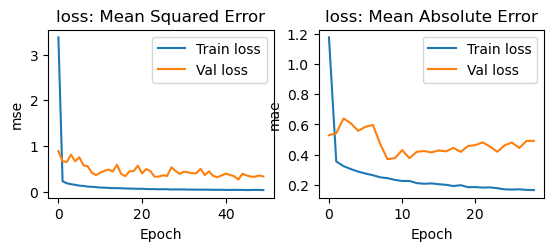

In [23]:
plt.subplot(2, 2, 1)
plt.plot(history_mse.history['loss'])
plt.plot(history_mse.history['val_loss'])
plt.title('loss: Mean Squared Error', fontsize=12)
plt.ylabel('mse')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

plt.subplot(2, 2, 2)
plt.plot(history_mae.history['loss'])
plt.plot(history_mae.history['val_loss'])
plt.title('loss: Mean Absolute Error', fontsize=12)
plt.ylabel('mae')
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [24]:
model_path = os.path.join(cwd,'saved_model')
os.makedirs(model_path, exist_ok=True)
model_mse.save(os.path.join(model_path,'NN_mse_model.h5'))
model_mae.save(os.path.join(model_path, 'NN_mae_model.h5'))

##### NN + keras tuner

In [52]:
x_train_flattened = x_train.reshape(x_train.shape[0], -1)  # x_train.shape[0] is the number of samples
y_train_flattened = y_train.reshape(y_train.shape[0], -1)

In [65]:
N_layers = 2
minibatch_size = 64
num_epochs = 80

def NN_model(hp):
    # options for hyperparameters
    hp_neuron = hp.Choice('neurons', values=[16, 32])
    hp_kernel_size = hp.Choice('kernel_size', values=[2, 3, 4, 5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    
    model_mse = Sequential()
    model_mse.add(Dense(hp_neuron*x_train_flattened.shape[1],  activation=hp_activation, name="hidden_layer_1" ,input_shape=(x_train_flattened.shape[1],)))
    for n in range(N_layers-1):
        model_mse.add(Dense(hp_neuron*x_train_flattened.shape[1],  activation=activation, name="hidden_layer_"+str(n+2))) 
    model_mse.add(Dense(y_train_flattened.shape[1],  activation='linear', name="output_layer")) # the output layer
    model_mse.compile(loss="mse",optimizer=tf.keras.optimizers.Adam(learning_rate=learning_rate))
    model_mse.summary()
    return model

In [67]:
random_tuner = keras_tuner.RandomSearch(NN_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        directory='random_search_NN', 
                                        project_name='random_search_NN_10trials')

early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

random_tuner.search(x_train_flattened, y_train_flattened,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

Reloading Tuner from random_search_NN/random_search_NN_10trials/tuner0.json

Search: Running Trial #5

Value             |Best Value So Far |Hyperparameter
32                |64                |filters
4                 |3                 |kernel_size
tanh              |tanh              |activation
0.01              |0.01              |learning_rate
mae               |mae               |loss

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 hidden_layer_1 (Dense)      (None, 3200)              643200    
                                                                 
 hidden_layer_2 (Dense)      (None, 3200)              10243200  
                                                                 
 output_layer (Dense)        (None, 25)                80025     
                                                                 
Total params: 10,966,425
Trainable params: 10,966,425
N

Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 232, in _build_and_fit_model
    model = self._try_build(hp)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 164, in _try_build
    model = self._build_hypermodel(hp)
  File "/srv/conda/envs/notebook/lib/python3.10/site

RuntimeError: Number of consecutive failures exceeded the limit of 3.
Traceback (most recent call last):
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 273, in _try_run_and_update_trial
    self._run_and_update_trial(trial, *fit_args, **fit_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/base_tuner.py", line 238, in _run_and_update_trial
    results = self.run_trial(trial, *fit_args, **fit_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 314, in run_trial
    obj_value = self._build_and_fit_model(trial, *args, **copied_kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/tuner.py", line 233, in _build_and_fit_model
    results = self.hypermodel.fit(hp, model, *args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras_tuner/src/engine/hypermodel.py", line 149, in fit
    return model.fit(*args, **kwargs)
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/utils/traceback_utils.py", line 70, in error_handler
    raise e.with_traceback(filtered_tb) from None
  File "/srv/conda/envs/notebook/lib/python3.10/site-packages/keras/engine/data_adapter.py", line 1668, in train_validation_split
    raise ValueError(
ValueError: `validation_split` is only supported for Tensors or NumPy arrays, found following types in the input: [<class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>, <class 'xarray.core.dataarray.DataArray'>]


##### CNN + Keras tuner

In [21]:
minibatch_size = 64
num_epochs     = 80
n_trials       = 10   # total number of trials in hyperparameter tuning

In [22]:
def CNN_model(hp):
    
    # options for hyperparameters
    hp_filters = hp.Choice('filters', values=[16,32,64])
    hp_kernel_size = hp.Choice('kernel_size', values=[2,3,4,5])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    
    # build CNN models according to the hyperparameters
    model = keras.models.Sequential()

    model.add(Dense(hp_filters*5*5, input_shape=x_train.shape[1:], activation=hp_activation)) 
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (5,5,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (48,72,filters)
    
    model.add(Conv2DTranspose(filters=hp_filters, kernel_size=hp_kernel_size, 
                              activation=hp_activation, strides=1, padding='same')) # shape: (96,144,filters)
    
    model.add(Conv2DTranspose(filters=1, kernel_size=hp_kernel_size, 
                              activation="linear", padding="same")) # shape: (96,144,1)
    
    model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    
    return model

In [76]:
random_tuner = keras_tuner.RandomSearch(CNN_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='random_search_CNN_10trials')

In [77]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)


In [79]:
random_tuner.search(x_train_np, y_train_np,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

Trial 10 Complete [00h 00m 44s]
val_loss: 0.9716030359268188

Best val_loss So Far: 0.1266775131225586
Total elapsed time: 00h 23m 45s


In [80]:
best_model = random_tuner.get_best_models()[0]
best_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 5, 5, 800)         7200      
                                                                 
 conv2d_transpose (Conv2DTra  (None, 5, 5, 32)         640032    
 nspose)                                                         
                                                                 
 conv2d_transpose_1 (Conv2DT  (None, 5, 5, 32)         25632     
 ranspose)                                                       
                                                                 
 conv2d_transpose_2 (Conv2DT  (None, 5, 5, 32)         25632     
 ranspose)                                                       
                                                                 
 conv2d_transpose_3 (Conv2DT  (None, 5, 5, 1)          801       
 ranspose)                                              

In [81]:
all_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)

# print the hyperparameters of the top 3 tuning trials
for it in range(3):
    print("Ranking #", str(it+1).zfill(1), "of best tuning, total trials = ", str(n_trials))
    print(all_hps[it].values)
    print("=============================================================================================")


# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

Ranking # 1 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 5, 'activation': 'relu', 'learning_rate': 0.01, 'loss': 'mse'}
Ranking # 2 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 3, 'activation': 'tanh', 'learning_rate': 0.001, 'loss': 'mse'}
Ranking # 3 of best tuning, total trials =  10
{'filters': 32, 'kernel_size': 2, 'activation': 'relu', 'learning_rate': 0.0001, 'loss': 'mae'}


In [82]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(x_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(x_train, y_train,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])

Epoch 1/80
119/119 [==============================] - 9s 71ms/step - loss: 55.8466 - val_loss: 5.8398
Epoch 2/80
119/119 [==============================] - 8s 69ms/step - loss: 13.9084 - val_loss: 2.8493
Epoch 3/80
119/119 [==============================] - 8s 72ms/step - loss: 9.0837 - val_loss: 1.0253
Epoch 4/80
119/119 [==============================] - 9s 73ms/step - loss: 5.6151 - val_loss: 0.2682
Epoch 5/80
119/119 [==============================] - 8s 69ms/step - loss: 3.3661 - val_loss: 0.2464
Epoch 6/80
119/119 [==============================] - 8s 70ms/step - loss: 2.0292 - val_loss: 0.6285
Epoch 7/80
119/119 [==============================] - 8s 69ms/step - loss: 1.3000 - val_loss: 1.1536
Epoch 8/80
119/119 [==============================] - 8s 70ms/step - loss: 0.9352 - val_loss: 1.6622
Epoch 9/80
119/119 [==============================] - 8s 70ms/step - loss: 0.7690 - val_loss: 2.0738
Epoch 10/80
119/119 [==============================] - 8s 70ms/step - loss: 0.7000 - val_

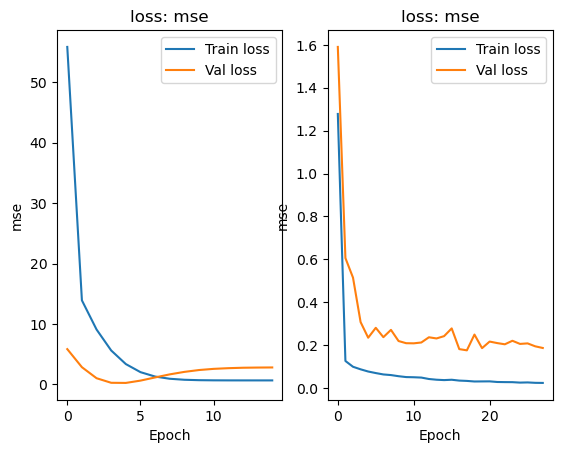

In [83]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [87]:
model_path = os.path.join(cwd,'saved_model')
os.makedirs(model_path, exist_ok=True)


In [88]:
model_best.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


##### LSTM + keras tuner

In [17]:
# set hyperparameters
num_epochs     = 50
minibatch_size = 64
n_trials = 12

In [18]:
def LSTM_model(hp):

    hp_neuron = hp.Choice('filters', values=[32, 64, 128])
    hp_activation = hp.Choice('activation', values=['relu', 'tanh', 'sigmoid'])
    hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4, 1e-5])
    hp_loss = hp.Choice('loss', values=['mse','mae'])
    LSTM_model = Sequential()
    LSTM_model.add(Reshape((input_shape[0], flattened_spatial_dim), input_shape=input_shape))
    LSTM_model.add(LSTM(hp_neuron, return_sequences=True, activation=hp_activation))
    LSTM_model.add(LSTM(hp_neuron, return_sequences=False, activation=hp_activation))
    LSTM_model.add(Dense(output_shape[0] * output_shape[1], activation="linear"))
    LSTM_model.add(Reshape(output_shape))

    LSTM_model.compile(loss=hp_loss, optimizer=tf.keras.optimizers.Adam(learning_rate=hp_learning_rate))
    return LSTM_model


In [19]:
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=20)

random_tuner = keras_tuner.RandomSearch(LSTM_model, 
                                        max_trials=n_trials,
                                        seed=5,
                                        objective='val_loss', 
                                        max_retries_per_trial=0,
                                        max_consecutive_failed_trials=3,
                                        directory='random_search', 
                                        project_name='random_search_LSTM_12trials')

Reloading Tuner from random_search/random_search_LSTM_12trials/tuner0.json


In [20]:
random_tuner.search(x_train_slider, y_train_slider,
                    batch_size = minibatch_size,
                    epochs = num_epochs, 
                    validation_split = 0.2, 
                    callbacks = [early_stop])

In [21]:
# get the hyperparameters of the best tuning trial
best_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[0]

# get the hyperparameters of the second ranking tuning trial
top2_hps = random_tuner.get_best_hyperparameters(num_trials=n_trials)[1]

In [22]:
## Build the model with the optimal hyperparameters
# ---------- best tuning ----------
model_best = random_tuner.hypermodel.build(best_hps)

# ---------- ranking #2 tuning ----------
model_top2 = random_tuner.hypermodel.build(top2_hps)



## re-train the model
# ---------- best tuning ----------
history_best = model_best.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])
# ---------- ranking #2 tuning ----------
history_top2 = model_top2.fit(x_train_slider, y_train_slider,
                              batch_size      = minibatch_size,
                              epochs          = num_epochs,
                              validation_split= 0.2, 
                              verbose         = 1,
                              callbacks       = [early_stop])


2023-12-18 17:31:11.840047: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 17:31:11.841589: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 17:31:11.843126: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

Epoch 1/50
119/119 [==============================] - 3s 13ms/step - loss: 5.6804 - val_loss: 2.2358
Epoch 2/50
119/119 [==============================] - 1s 10ms/step - loss: 0.5615 - val_loss: 0.5554
Epoch 3/50
119/119 [==============================] - 1s 9ms/step - loss: 0.2339 - val_loss: 0.1387
Epoch 4/50
119/119 [==============================] - 1s 10ms/step - loss: 0.1149 - val_loss: 0.1299
Epoch 5/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0862 - val_loss: 0.1357
Epoch 6/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0745 - val_loss: 0.1321
Epoch 7/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0665 - val_loss: 0.1239
Epoch 8/50
119/119 [==============================] - 1s 9ms/step - loss: 0.0608 - val_loss: 0.1254
Epoch 9/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0557 - val_loss: 0.1257
Epoch 10/50
119/119 [==============================] - 1s 10ms/step - loss: 0.0517 - val_loss: 

2023-12-18 17:31:45.187928: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 17:31:45.189646: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 17:31:45.190631: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

118/119 [============================>.] - ETA: 0s - loss: 0.8659

2023-12-18 17:31:49.974533: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 17:31:49.975967: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 17:31:49.976997: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

119/119 [==============================] - 6s 24ms/step - loss: 0.8617 - val_loss: 0.2643
Epoch 2/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0778 - val_loss: 0.2033
Epoch 3/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0617 - val_loss: 0.1890
Epoch 4/50
119/119 [==============================] - 2s 19ms/step - loss: 0.0447 - val_loss: 0.2530
Epoch 5/50
119/119 [==============================] - 2s 18ms/step - loss: 0.0383 - val_loss: 0.2289
Epoch 6/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0331 - val_loss: 0.1497
Epoch 7/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0266 - val_loss: 0.1430
Epoch 8/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0248 - val_loss: 0.1558
Epoch 9/50
119/119 [==============================] - 2s 17ms/step - loss: 0.0238 - val_loss: 0.1610
Epoch 10/50
119/119 [==============================] - 2s 19ms/step - loss: 0.0211 - val_loss: 0.1482


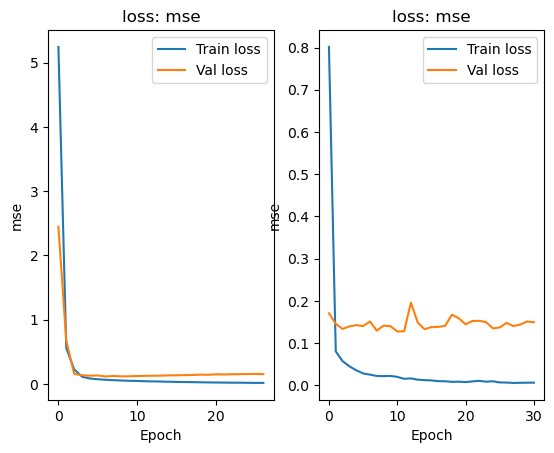

In [30]:
## set up title and ylabel strings
# ---------- best tuning ----------
title_best = 'loss: '+str(best_hps['loss'])
ylabel_best = best_hps['loss']
# ---------- ranking #2 tuning ----------
title_top2 = 'loss: '+str(top2_hps['loss'])
ylabel_top2 = top2_hps['loss']


## plot history
# ---------- best tuning ----------
plt.subplot(1, 2, 1)
plt.plot(history_best.history['loss'])
plt.plot(history_best.history['val_loss'])
plt.title(title_best, fontsize=12)
plt.ylabel(ylabel_best)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

# ---------- ranking #2 tuning ----------
plt.subplot(1, 2, 2)
plt.plot(history_top2.history['loss'])
plt.plot(history_top2.history['val_loss'])
plt.title(title_top2, fontsize=12)
plt.ylabel(ylabel_top2)
plt.xlabel('Epoch')
plt.legend(['Train loss', 'Val loss'], fontsize=10, loc='upper right')

In [31]:
model_path = os.path.join(cwd,'saved_model')
model_best.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2.save(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))

#### Test Model
- NN
- NN + keras tuner
- CNN + keras tuner
- LSTM + keras tuner
- CNN_LSTM + keras tuner

##### NN

In [53]:
model_mse = load_model(os.path.join(model_path,'NN_mse_model.h5'))
model_mae = load_model(os.path.join(model_path,'NN_mae_model.h5'))


In [54]:
y_test_mse_pre = model_mse.predict(x_test_flattened)
y_test_mae_pre = model_mae.predict(x_test_flattened)

53/53 [==============================] - 0s 627us/step


In [55]:
y_test_mse_pre = y_test_mse_pre.reshape(y_test_mse_pre.shape[0], 5, 5)
y_test_mse_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mse_pre)))

y_test_mae_pre = y_test_mae_pre.reshape(y_test_mae_pre.shape[0], 5, 5)
y_test_mae_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_mae_pre)))


In [56]:
y_test_mse_pre

<xarray.Dataset>
Dimensions:    (time: 1673, latitude: 5, longitude: 5)
Coordinates:
  * time       (time) datetime64[ns] 2019-01-01 2019-01-02 ... 2023-07-31
  * latitude   (latitude) float32 82.92 83.0 83.08 83.17 83.25
  * longitude  (longitude) float32 -58.08 -58.0 -57.92 -57.83 -57.75
Data variables:
    sithick    (time, latitude, longitude) float32 2.94 2.836 ... 3.127 3.173

##### CNN + keras tuner

In [56]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'CNN_model_randomsearch_10trials_rank2.h5'))


In [57]:
y_test_best_pre = model_best.predict(x_test_np)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], 5, 5)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_np)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], 5, 5)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values, 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))


53/53 [==============================] - 0s 6ms/step


##### LSTM + keras tuner

In [32]:
## reload the saved model
model_best = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank1.h5'))
model_top2 = load_model(os.path.join(model_path,'LSTM_model_randomsearch_12trials_rank2.h5'))


2023-12-18 17:08:58.283573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-12-18 17:08:58.284901: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-12-18 17:08:58.286195: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [42]:
y_test_best_pre = model_best.predict(x_test_slider)
y_test_best_pre = y_test_best_pre.reshape(y_test_best_pre.shape[0], 5, 5)
y_test_best_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_best_pre)))
# ---------- rank #2 tuning ----------
y_test_top2_pre = model_top2.predict(x_test_slider)
y_test_top2_pre = y_test_top2_pre.reshape(y_test_top2_pre.shape[0], 5, 5)
y_test_top2_pre = xr.Dataset(coords={'time': x_test_xr.time.values[slider-1:], 
                                     'latitude': x_test_xr.latitude.values, 
                                     'longitude': x_test_xr.longitude.values},
                             data_vars=dict(sithick=(['time', 'latitude', 'longitude'], y_test_top2_pre)))

53/53 [==============================] - 0s 4ms/step
